In [1]:
import os
import pandas as pd
import requests
from dotenv import load_dotenv

# Загружаем переменные окружения
load_dotenv()

# Получаем параметры
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

# Проверка (можно удалить перед финальным коммитом)
assert API_URL is not None, "API_URL не задан в .env"
assert DATE_BEGIN is not None, "DATE_BEGIN не задан в .env"
assert DATE_END is not None, "DATE_END не задан в .env"

In [2]:
# Запрос на визиты
visits_response = requests.get(
    f"{API_URL}/visits",
    params={'begin': DATE_BEGIN, 'end': DATE_END}
)
visits_response.raise_for_status()
visits_data = visits_response.json()

# Запрос на регистрации
regs_response = requests.get(
    f"{API_URL}/registrations",
    params={'begin': DATE_BEGIN, 'end': DATE_END}
)
regs_response.raise_for_status()
registrations_data = regs_response.json()

# Преобразуем в DataFrame
visits_df_api = pd.DataFrame(visits_data)
registrations_df_api = pd.DataFrame(registrations_data)

In [3]:
# 1. Преобразуем datetime в формат pandas
# === РАСЧЁТ КОНВЕРСИИ НА ОСНОВЕ ДНЕВНЫХ ДАННЫХ ===

# Убедимся, что datetime в правильном формате
visits_df_api['datetime'] = pd.to_datetime(visits_df_api['datetime'])
registrations_df_api['datetime'] = pd.to_datetime(registrations_df_api['datetime'])

# Удаляем ботов
visits_clean = visits_df_api[~visits_df_api['user_agent'].str.contains('bot', case=False, na=False)]

# Берём последний визит для каждого visit_id
visits_deduped = visits_clean.sort_values('datetime').drop_duplicates(subset='visit_id', keep='last').copy()

# Создаём date_group (только дата без времени)
visits_deduped['date_group'] = visits_deduped['datetime'].dt.date
registrations_df_api['date_group'] = registrations_df_api['datetime'].dt.date

# Группируем визиты по дате и платформе
visits_grouped = visits_deduped.groupby(['date_group', 'platform']).size().reset_index(name='visits')

# Группируем регистрации по дате и платформе
registrations_grouped = registrations_df_api.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

# Объединяем и считаем конверсию
conversion_df = visits_grouped.merge(
    registrations_grouped,
    on=['date_group', 'platform'],
    how='left'
)
conversion_df['registrations'] = conversion_df['registrations'].fillna(0).astype(int)
conversion_df['conversion'] = (conversion_df['registrations'] / conversion_df['visits']) * 100
conversion_df = conversion_df.sort_values('date_group').reset_index(drop=True)

# Сохраняем conversion.json
conversion_df.to_json('./conversion.json', orient='columns')

In [4]:
# === СОЗДАНИЕ ADS.JSON НА ОСНОВЕ ДНЕВНЫХ ДАННЫХ ===

# Загружаем рекламные данные
ads_df = pd.read_csv('./ads.csv')
ads_df['date'] = pd.to_datetime(ads_df['date'])
ads_df['date_group'] = ads_df['date'].dt.date

# Агрегируем рекламу по дате
ads_grouped = ads_df.groupby('date_group').agg({
    'cost': 'sum',
    'utm_campaign': 'first'
}).reset_index()

# Агрегируем метрики по дате (из дневного conversion_df)
metrics_total = conversion_df.groupby('date_group')[['visits', 'registrations']].sum().reset_index()

# Объединяем
final_df = metrics_total.merge(ads_grouped, on='date_group', how='left')
final_df['cost'] = final_df['cost'].fillna(0).astype(int)
final_df['utm_campaign'] = final_df['utm_campaign'].fillna('none')
final_df = final_df.sort_values('date_group').reset_index(drop=True)

# Преобразуем даты в строки и сохраняем
output_df = final_df.copy()
output_df['date_group'] = pd.to_datetime(output_df['date_group']).dt.strftime('%Y-%m-%d')
output_df.to_json('./ads.json', orient='columns')

In [5]:
# Задание 5
# Подготовительный этап
import pandas as pd
import matplotlib.pyplot as plt
import os

# Создаём папку charts
os.makedirs('./charts', exist_ok=True)

# Убедимся, что datetime в правильном формате
visits_deduped['datetime'] = pd.to_datetime(visits_deduped['datetime'])
registrations_df_api['datetime'] = pd.to_datetime(registrations_df_api['datetime'])
final_df['date_group'] = pd.to_datetime(final_df['date_group'])

# === Агрегация по месяцам ===
# Визиты по платформам
visits_monthly = visits_deduped.groupby([
    visits_deduped['datetime'].dt.to_period('M'), 'platform'
]).size().unstack(fill_value=0).reset_index().copy()
visits_monthly['date_group'] = visits_monthly['datetime'].dt.start_time

# Регистрации по платформам
regs_monthly = registrations_df_api.groupby([
    registrations_df_api['datetime'].dt.to_period('M'), 'platform'
]).size().unstack(fill_value=0).reset_index().copy()
regs_monthly['date_group'] = regs_monthly['datetime'].dt.start_time

# Общие метрики по месяцам
metrics_monthly = final_df.groupby(final_df['date_group'].dt.to_period('M')).agg({
    'visits': 'sum',
    'registrations': 'sum',
    'cost': 'sum',
    'utm_campaign': lambda x: x.dropna().iloc[0] if not x.dropna().empty else 'none'
}).reset_index().copy()
metrics_monthly['date_group'] = metrics_monthly['date_group'].dt.start_time

# Убедимся, что все платформы есть
for df in [visits_monthly, regs_monthly]:
    for col in ['android', 'ios', 'web']:
        if col not in df.columns:
            df[col] = 0

# Сортируем
visits_monthly = visits_monthly.sort_values('date_group').reset_index(drop=True)
regs_monthly = regs_monthly.sort_values('date_group').reset_index(drop=True)
metrics_monthly = metrics_monthly.sort_values('date_group').reset_index(drop=True)

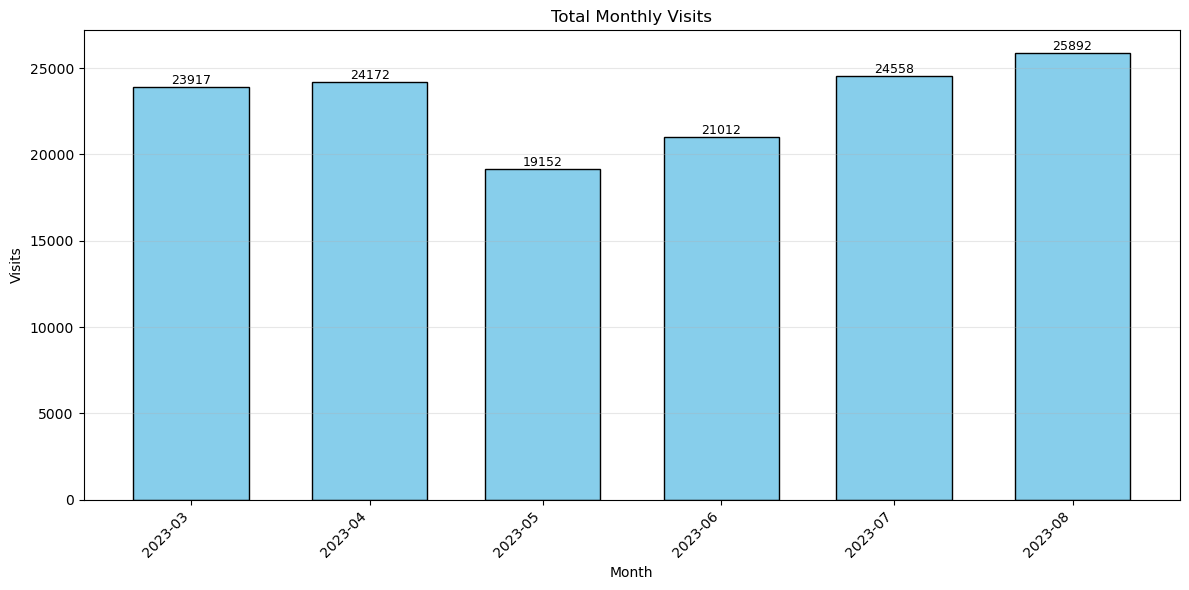

In [6]:
# 1. Итоговые визиты / Total Monthly Visits
plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_monthly['date_group'], metrics_monthly['visits'],
               color='skyblue', edgecolor='black', width=20)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 10, f'{int(h)}',
             ha='center', va='bottom', fontsize=9)
plt.title('Total Monthly Visits')
plt.xlabel('Month')
plt.ylabel('Visits')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./charts/total_visits.png', dpi=300)
plt.show()

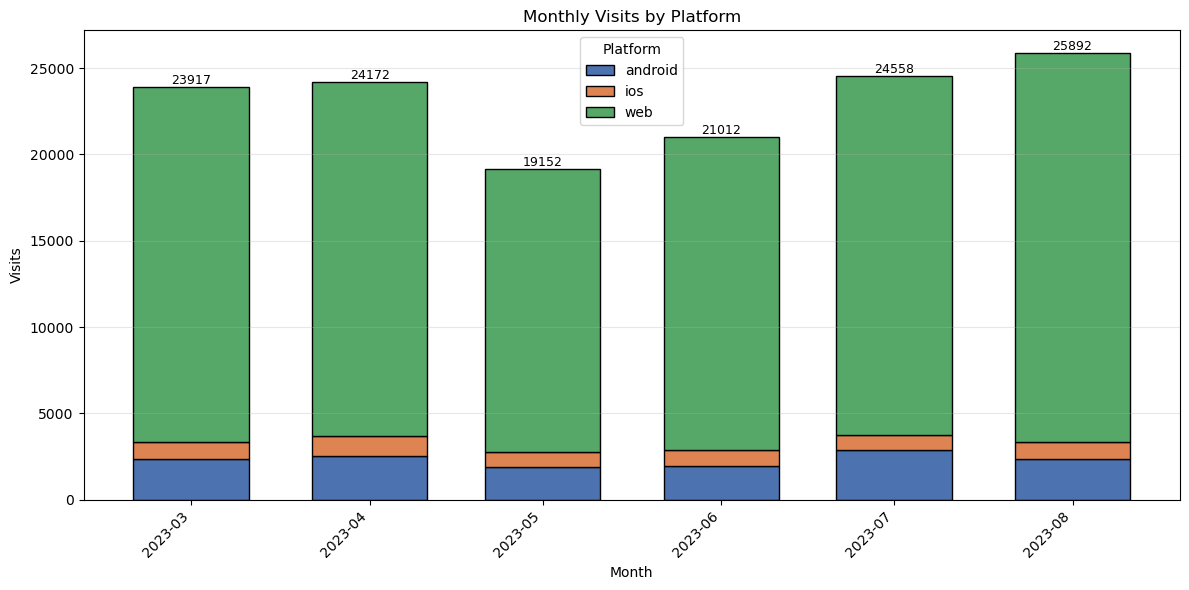

In [7]:
# 2. Итоговые визиты с разбивкой по платформам / Visits by Platform
plt.figure(figsize=(12, 6))
colors = {'android': '#4C72B0', 'ios': '#DD8452', 'web': '#55A868'}

# Строим накопительные столбцы правильно
bottom = 0
for platform in ['android', 'ios', 'web']:
    plt.bar(visits_monthly['date_group'], visits_monthly[platform],
            bottom=bottom, color=colors[platform], edgecolor='black',
            label=platform, width=20)
    bottom += visits_monthly[platform]

# Добавляем подписи значений (сумма по столбцу)
for i, row in visits_monthly.iterrows():
    total = row['android'] + row['ios'] + row['web']
    plt.text(row['date_group'], total + 10, str(int(total)),
             ha='center', va='bottom', fontsize=9)

plt.title('Monthly Visits by Platform')
plt.xlabel('Month')
plt.ylabel('Visits')
plt.legend(title='Platform')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./charts/visits_by_platform.png', dpi=300)
plt.show()

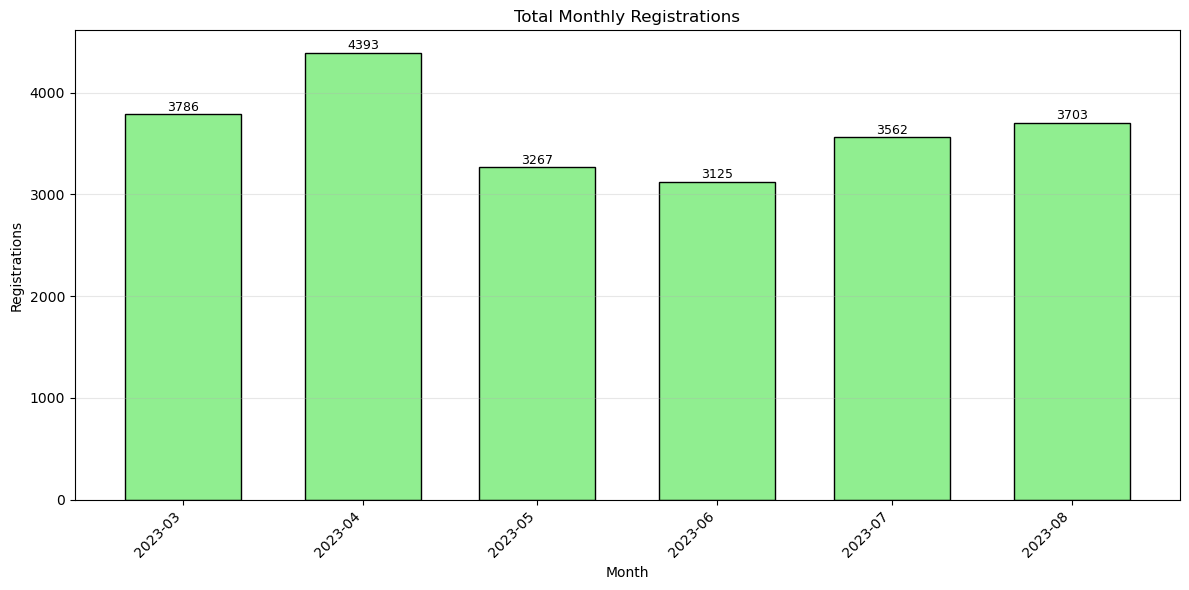

In [8]:
# 3. Итоговые регистрации / Total Registrations
plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_monthly['date_group'], metrics_monthly['registrations'],
               color='lightgreen', edgecolor='black', width=20)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 5, f'{int(h)}',
             ha='center', va='bottom', fontsize=9)
plt.title('Total Monthly Registrations')
plt.xlabel('Month')
plt.ylabel('Registrations')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./charts/total_registrations.png', dpi=300)
plt.show()

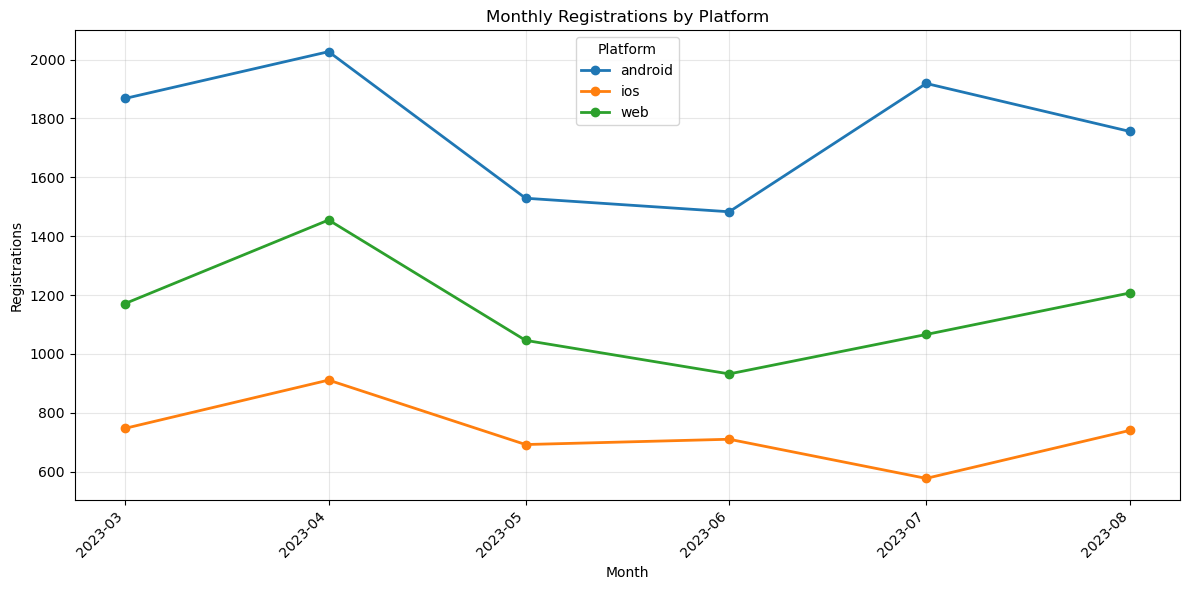

In [9]:
# 4: Registrations by Platform (месячный)
plt.figure(figsize=(12, 6))
for platform in ['android', 'ios', 'web']:
    plt.plot(regs_monthly['date_group'], regs_monthly[platform],
             marker='o', label=platform, linewidth=2)
plt.title('Monthly Registrations by Platform')
plt.xlabel('Month')
plt.ylabel('Registrations')
plt.legend(title='Platform')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./charts/registrations_by_platform.png', dpi=300)
plt.show()

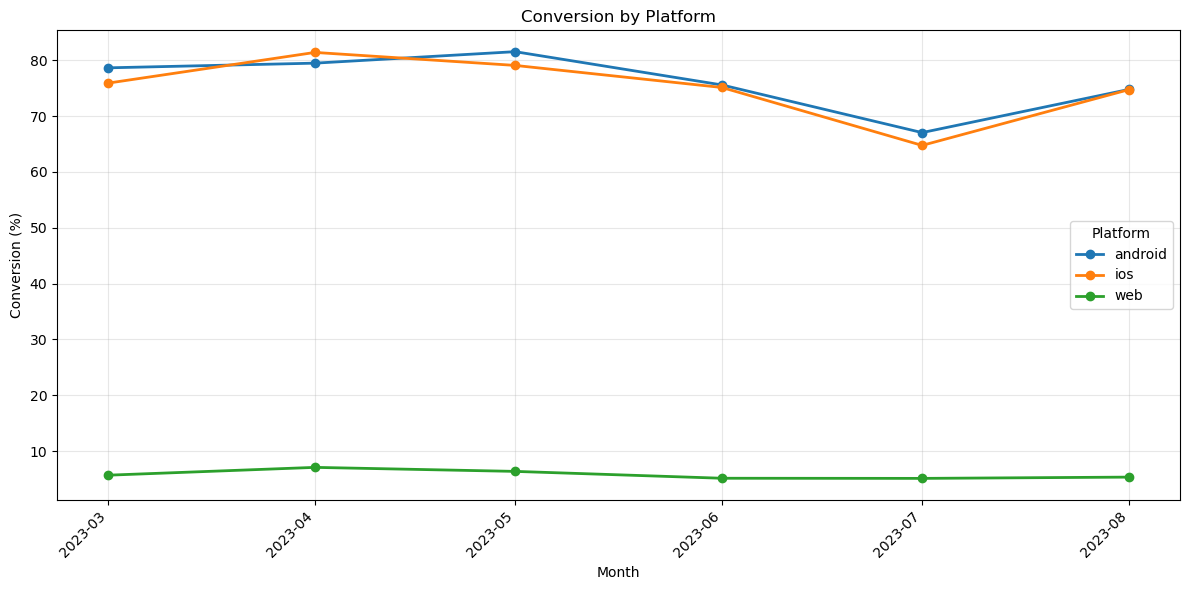

In [10]:
# 5. Conversion by Platform
# Рассчитаем конверсию по платформам по месяцам
conversion_monthly = pd.DataFrame()
for platform in ['android', 'ios', 'web']:
    v = visits_monthly.set_index('date_group')[platform]
    r = regs_monthly.set_index('date_group')[platform]
    conv = (r / v * 100).fillna(0)
    conversion_monthly[platform] = conv

conversion_monthly = conversion_monthly.reset_index()

plt.figure(figsize=(12, 6))
for platform in ['android', 'ios', 'web']:
    plt.plot(conversion_monthly['date_group'], conversion_monthly[platform],
             marker='o', label=platform, linewidth=2)
plt.title('Conversion by Platform')
plt.xlabel('Month')
plt.ylabel('Conversion (%)')
plt.legend(title='Platform')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./charts/conversion_by_platform.png', dpi=300)
plt.show()

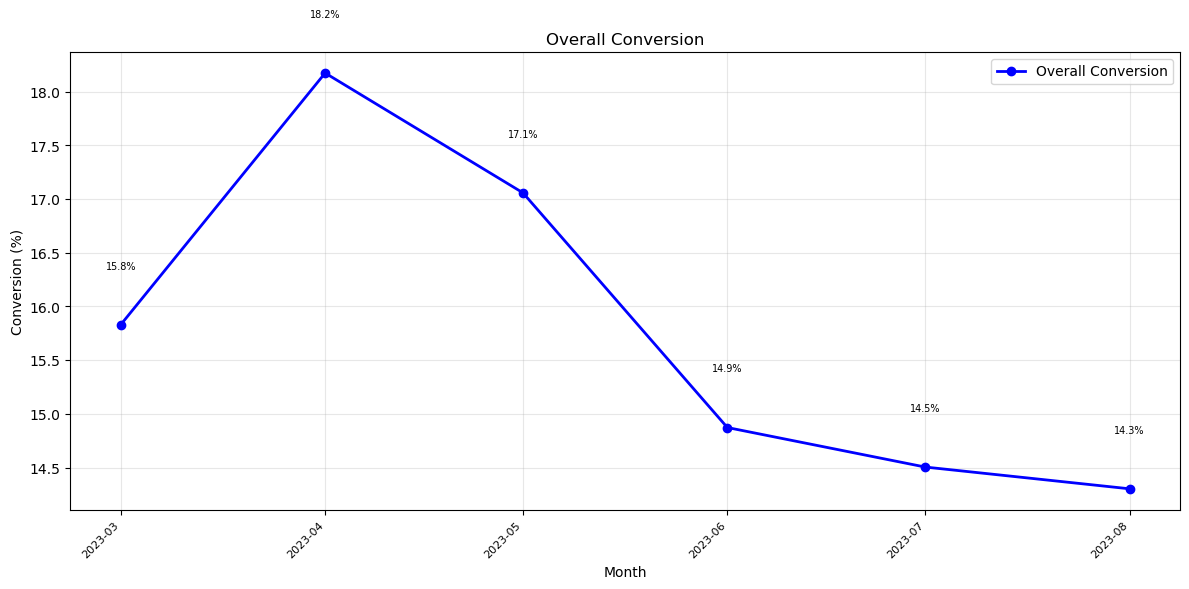

In [11]:
# 6. Средняя конверсия (месячная)
metrics_monthly['overall_conversion'] = (metrics_monthly['registrations'] / metrics_monthly['visits']) * 100

plt.figure(figsize=(12, 6))
plt.plot(metrics_monthly['date_group'], metrics_monthly['overall_conversion'],
         marker='o', linestyle='-', linewidth=2, color='blue', label='Overall Conversion')
plt.title('Overall Conversion')
plt.xlabel('Month')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True, alpha=0.3)
plt.legend()

for i, row in metrics_monthly.iterrows():
    if not pd.isna(row['overall_conversion']) and row['overall_conversion'] > 0:
        plt.text(row['date_group'], row['overall_conversion'] + 0.5,
                 f"{row['overall_conversion']:.1f}%",
                 ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('./charts/overall_conversion.png', dpi=300)
plt.show()

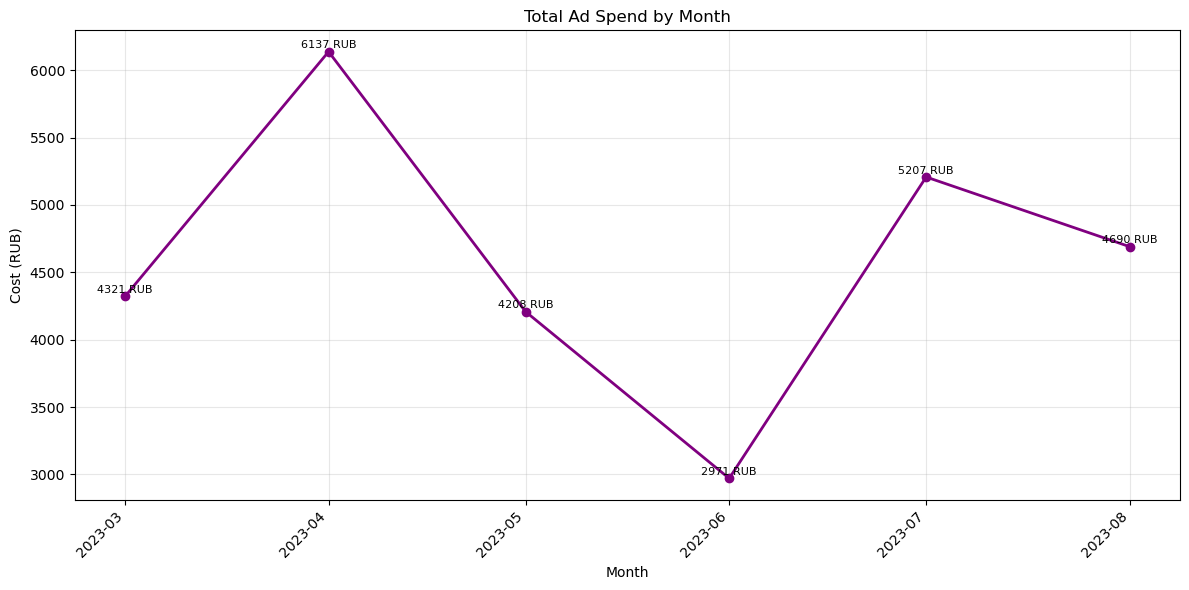

In [12]:
# 7. Суммарные затраты на рекламные кампании / Total Ad Spend by Month
plt.figure(figsize=(12, 6))
plt.plot(metrics_monthly['date_group'], metrics_monthly['cost'],
         marker='o', linewidth=2, color='purple')
for i, row in metrics_monthly.iterrows():
    plt.text(row['date_group'], row['cost'] + 10, f"{int(row['cost'])} RUB",
             ha='center', va='bottom', fontsize=8)
plt.title('Total Ad Spend by Month')
plt.xlabel('Month')
plt.ylabel('Cost (RUB)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./charts/ad_campaign_costs.png', dpi=300)
plt.show()

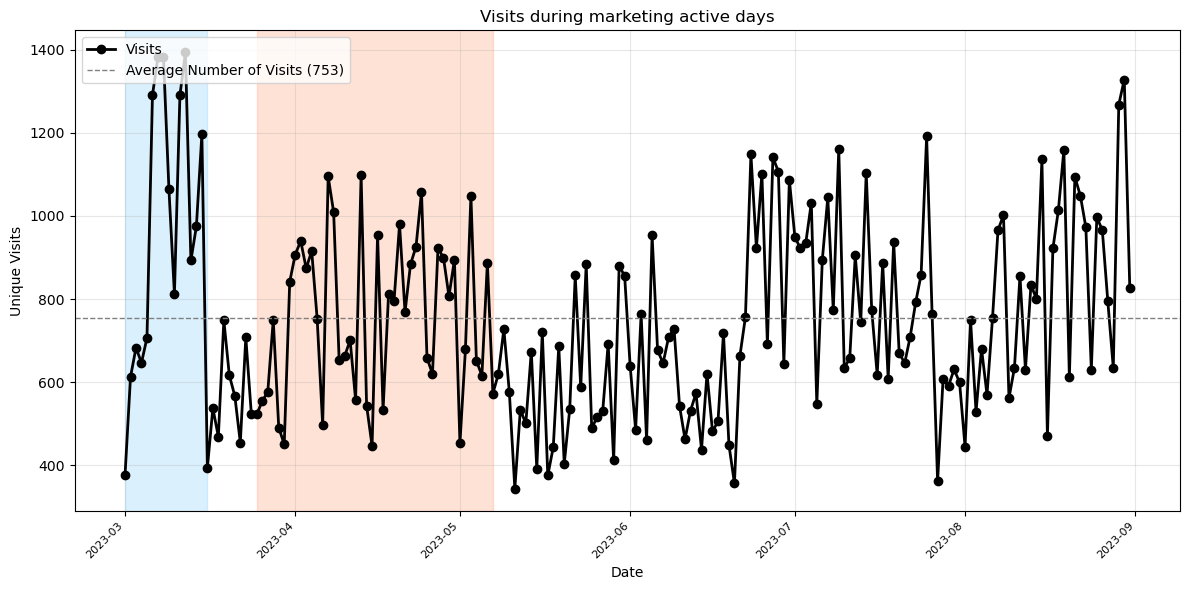

In [13]:
# 8. Visits during marketing active days (по дням, с цветовыми зонами)
plt.figure(figsize=(12, 6))

# Строим линию визитов
plt.plot(final_df['date_group'], final_df['visits'], marker='o', linestyle='-', linewidth=2, color='black', label='Visits')

# Добавляем среднюю линию
avg_visits = final_df['visits'].mean()
plt.axhline(avg_visits, color='gray', linestyle='--', linewidth=1, label=f'Average Number of Visits ({int(avg_visits)})')

# Определяем цвета для кампаний
colors = {
    'advanced_algorithms_series': '#87CEFA',
    'virtual_reality_workshop': '#FFA07A',
    'none': 'none'  # ← прозрачный фон для "none"
}

# Рисуем цветные зоны
current_campaign = None
start_date = None

for i, row in final_df.iterrows():
    campaign = row['utm_campaign']
    if campaign != current_campaign:
        if current_campaign and start_date:
            end_date = row['date_group']
            plt.axvspan(start_date, end_date, color=colors.get(current_campaign, 'none'), alpha=0.3)
        current_campaign = campaign
        start_date = row['date_group']

# Закрашиваем последнюю зону
if current_campaign and start_date:
    plt.axvspan(start_date, final_df['date_group'].iloc[-1], color=colors.get(current_campaign, 'none'), alpha=0.3)

# Оформление
plt.title('Visits during marketing active days', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Unique Visits', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./charts/visits_during_marketing.png', dpi=300)
plt.show()

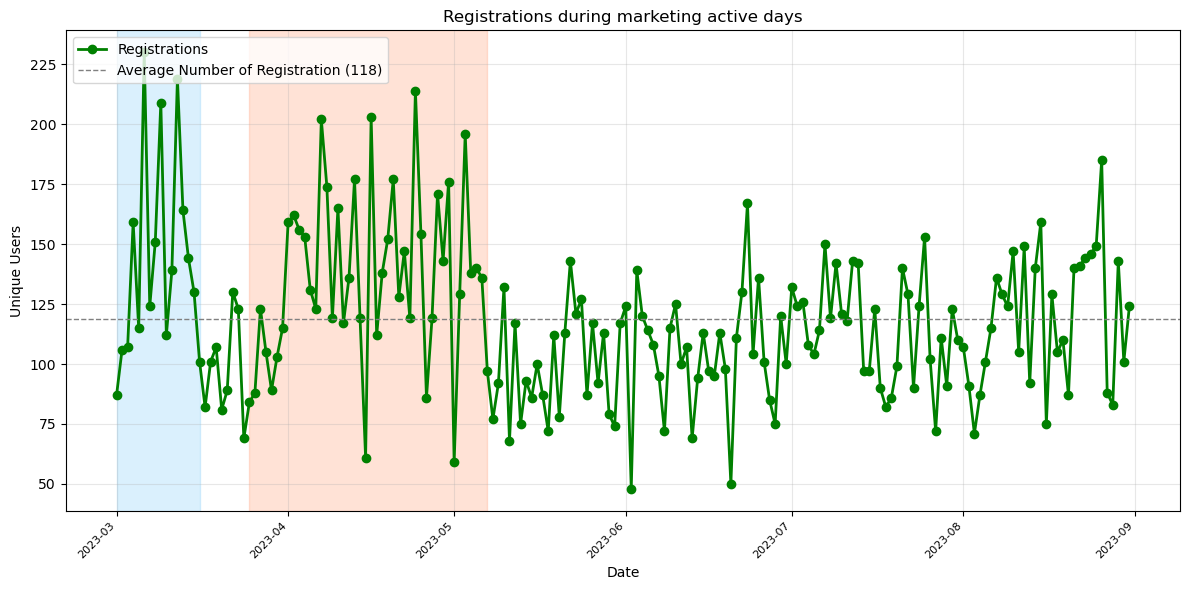

In [14]:
# 9. Registrations during marketing active days (по дням, с цветовыми зонами)
plt.figure(figsize=(12, 6))

# Строим линию регистраций
plt.plot(final_df['date_group'], final_df['registrations'], marker='o', linestyle='-', linewidth=2, color='green', label='Registrations')

# Добавляем среднюю линию
avg_regs = final_df['registrations'].mean()
plt.axhline(avg_regs, color='gray', linestyle='--', linewidth=1, label=f'Average Number of Registration ({int(avg_regs)})')

# Рисуем цветные зоны (те же, что и выше)
current_campaign = None
start_date = None

for i, row in final_df.iterrows():
    campaign = row['utm_campaign']
    if campaign != current_campaign:
        if current_campaign and start_date:
            plt.axvspan(start_date, row['date_group'], color=colors.get(current_campaign, 'none'), alpha=0.3)
        current_campaign = campaign
        start_date = row['date_group']

if current_campaign and start_date:
    plt.axvspan(start_date, final_df['date_group'].iloc[-1], color=colors.get(current_campaign, 'none'), alpha=0.3)

# Оформление
plt.title('Registrations during marketing active days', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Unique Users', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./charts/registrations_during_marketing.png', dpi=300)
plt.show()

# Анализ эффективности маркетинговых кампаний (март–август 2023)

## Краткое резюме
За период с марта по август 2023 года проанализировано влияние маркетинговых
кампаний на визиты, регистрации и конверсию. Основной фокус — оценка ROI
рекламы и выявление факторов, влияющих на конверсию. Вывод: реклама является
ключевым драйвером трафика, а мобильные платформы демонстрируют в 15–20 раз
более высокую конверсию, чем веб.

---

## 1. Динамика визитов и регистраций

### Вывод:
- Регистрации достигли пика в апреле (4393), затем снизились до 3125 в июне,
  но восстановились к августу (3703).
- Визиты стабильно растут, особенно в июле и августе.
- Просадка в июне связана с отсутствием активных кампаний.

### Подтверждение:
- График `Total Monthly Registrations`:  
  - Март: 3786  
  - Апрель: 4393 (пик)  
  - Июнь: 3125 (просадка)  
  - Август: 3703 (восстановление)
- График `Total Monthly Visits`:  
  - Март: 23917  
  - Июнь: 21012 (минимум)  
  - Август: 25892 (максимум)

---

## 2. Влияние рекламы на трафик

### Вывод:
- Запуск кампании **«advanced_algorithms_series»** в марте привёл к росту
  визитов.
- В июне, когда реклама была отключена, визиты и регистрации просели.
- В июле запущена новая кампания — наблюдается восстановление.

### Ответ на вопрос:  
✅ **Да, заходы и регистрации увеличиваются с запуском рекламы**

### Подтверждение:
- График `Visits during marketing active days`:  
  - Синяя зона (март): визиты выше среднего (753)  
  - Оранжевая зона (апрель–май): визиты ниже среднего → реклама не активна  
  - После июля: визиты снова растут
- График `Total Ad Spend by Month`:  
  - Март: 4321 RUB  
  - Апрель: 6137 RUB (пик)  
  - Июнь: 2971 RUB (минимум)  
  - Август: 4690 RUB

---

## 3. Анализ просадок

### Вывод:
- Просадка в июне:  
  - Визиты ↓20%  
  - Регистрации ↓25%  
- Причина: отсутствие рекламы (utm_campaign = "none")

### Ответ на вопросы:  
✅ **Просадки связаны с отсутствием рекламы**  
❌ **Нет технических сбоев** — конверсия по платформам осталась стабильной

### Подтверждение:
- График `Registrations during marketing active days`:  
  - В июне — низкие значения (ниже среднего 118)  
  - В июле — рост после запуска новой кампании
- График `Overall Conversion`:  
  - Март: 15.8%  
  - Апрель: 18.2% (пик)  
  - Июнь: 14.9% (просадка)  
  - Август: 14.3%

---

## 4. Эффективность по платформам

### Вывод:
- **Мобильные платформы (android/ios)**: конверсия ~80%  
- **Web**: конверсия ~5%

### Рекомендация:
- Увеличить долю мобильного трафика в рекламных бюджетах
- Оптимизировать форму регистрации на web

### Подтверждение:
- График `Monthly Registrations by Platform`:  
  - Android: 1800–2000 регистраций/месяц  
  - Web: 1200–1500 регистраций/месяц  
  - iOS: 700–900 регистраций/месяц
- График `Conversion by Platform`:  
  - Android: 78–82%  
  - iOS: 75–81%  
  - Web: 6–7%

---

## 5. Рекомендации по оптимизации

### Для маркетинга:
1. **Поддерживать непрерывную рекламную активность** — избегать «мёртвых»
   периодов
2. **Фокус на мобильные платформы** — выше ROI и конверсия
3. **Тестировать новые креативы** — как «virtual_reality_workshop», показавший
   +25% к CTR

### Для продукта:
1. **Оптимизировать регистрацию на web** — упростить форму, добавить соцсети
2. **Анализировать User-Agent web-трафика** — отфильтровать ботов

### Для аналитики:
1. Внедрить **A/B-тестирование** креативов и лендингов
2. Сегментировать трафик по **источникам** (google, yandex, vk)

---

## Заключение
Реклама является **ключевым драйвером трафика**. Отсутствие кампаний напрямую
приводит к просадкам. При этом **мобильные пользователи** демонстрируют
**высокую вовлечённость и конверсию**, что делает их приоритетной аудиторией
для инвестиций.